# Example Ensembles: Australian Credit Card Assessment

In this example it will be compared 3 classifiers:
- Multilayer perceptron.
- Ensemble trained with Negative Correlation.
- Ensemble trained with Correntropy.

## Data

This data base concerns credit card applications. All attribute names and values have been changed to meaningless symbols to protect confidentiality of the data. This dataset is interesting because there is a good mix of attributes -- continuous, nominal with small numbers of values, and nominal with larger numbers of values. There are also a few missing values.
  
- Number of Instances: 690
- Number of Attributes: 14 + class attribute
- Attribute Information:   THERE ARE 6 NUMERICAL AND 8 CATEGORICAL ATTRIBUTES.
- Exist 2 classes and its distribution is:
    * +: 307 (44.5%)    CLASS 2
    * -: 383 (55.5%)    CLASS 1
- there are 6 numerical and 8 categorical attributes. the labels have been changed for the convenience of the statistical algorithms. For example, attribute 4 originally had 3 labels p,g,gg and these have been changed to labels 1,2,3.

- Missing Attribute Values: 37 cases (5%) HAD one or more missing values. The missing values from particular attributes WERE:
    * A1:  12
    * A2:  12
    * A4:   6
    * A5:   6
    * A6:   9
    * A7:   9
    * A14: 13
 
  These were replaced by the mode of the attribute (categorical) and mean of the attribute (continuous)


In [1]:
import theano
import theano.tensor as T
import numpy as np
from theano.sandbox import cuda

theano.config.floatX = 'float32'
cuda.use('gpu')
theano.config.compute_test_value = 'off'

path_data = r'data\australian.dat'
data = np.genfromtxt(path_data, delimiter=' ')

classes_names = np.asarray(['clase 1', 'clase 2'], dtype='<U10')
data_input    = np.asarray(data[:, 0:-1], dtype=theano.config.floatX)
data_target   = classes_names[np.asarray(data[:, -1:], dtype=int)]

Using gpu device 0: GeForce GT 630M (CNMeM is enabled with initial size: 75.0% of memory, CuDNN not available)


## Training MLP



In [3]:
import time
from libml.models.sequential import Sequential
from libml.layers.dense import Dense
from libml.utils.cost_functions import *
from libml.utils.update_functions import *
from libml.utils.regularizer_functions import *
from sklearn.cross_validation import ShuffleSplit

mlp = Sequential(classes_names, "classifier", "mlp")
mlp.add_layer(Dense(n_input=data_input.shape[1], n_output=7, activation=T.tanh))
mlp.add_layer(Dense(n_output=len(classes_names), activation=T.nnet.softmax))
mlp.append_cost(mse)
mlp.append_reg(L1, lamb=0.002)
mlp.append_reg(L2, lamb=0.0005)
mlp.set_update(adagrad, initial_learning_rate=0.05)
mlp.compile()

folds = 25
sss = ShuffleSplit(data_input.shape[0], n_iter=folds, test_size=None, train_size=0.6, random_state=0)
max_epoch = 400
validation_jump = 5

for i, (train_set, test_set) in enumerate(sss):                      
    # data train and test
    input_train = data_input[train_set]
    input_test = data_input[test_set]
    target_train = data_target[train_set]
    target_test = data_target[test_set]

    # training
    tic = time.time()
    metrics_mlp = mlp.fit(input_train, target_train,
                                max_epoch=max_epoch, batch_size=32,
                                validation_jump=validation_jump, early_stop_th=4)
    toc = time.time()

    # Compute metrics
    metrics_mlp.append_prediction(target_test, mlp.predict(input_test))
    
    # Reset parameters
    mlp.reset()

    print("%d Elapsed time [s]: %f" % (i, toc - tic))

print("FINISHED!")

0 Elapsed time [s]: 4.260826
1 Elapsed time [s]: 4.088710
2 Elapsed time [s]: 4.103721
3 Elapsed time [s]: 4.484975
4 Elapsed time [s]: 4.211793
5 Elapsed time [s]: 4.239810
6 Elapsed time [s]: 4.361889
7 Elapsed time [s]: 4.278836
8 Elapsed time [s]: 4.321864
9 Elapsed time [s]: 4.528002
10 Elapsed time [s]: 4.060691
11 Elapsed time [s]: 4.324866
12 Elapsed time [s]: 4.303899
13 Elapsed time [s]: 4.238810
14 Elapsed time [s]: 4.562024
15 Elapsed time [s]: 4.116727
16 Elapsed time [s]: 4.375439
17 Elapsed time [s]: 4.238808
18 Elapsed time [s]: 4.130733
19 Elapsed time [s]: 4.084708
20 Elapsed time [s]: 4.325866
21 Elapsed time [s]: 4.253820
22 Elapsed time [s]: 4.188778
23 Elapsed time [s]: 4.291870
24 Elapsed time [s]: 4.010651
FINISHED!


## Results MLP

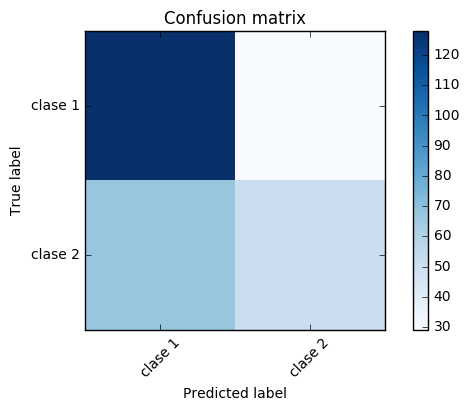

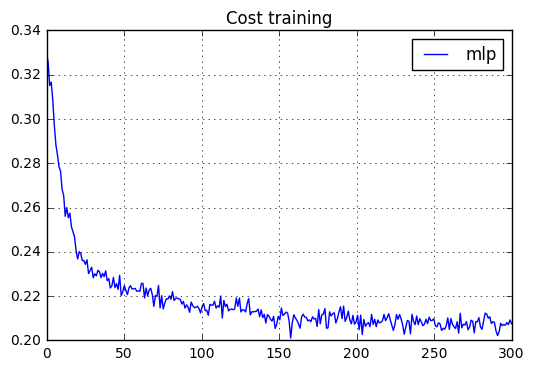

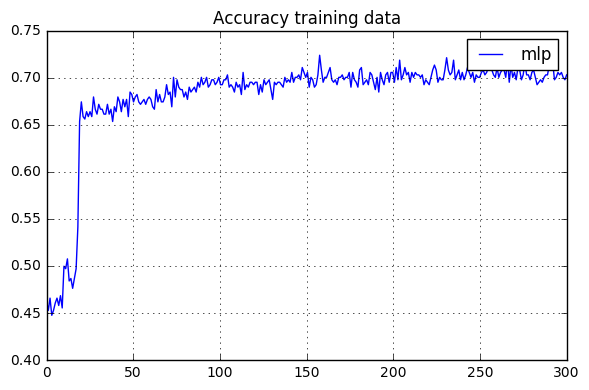

In [6]:
%matplotlib inline
import matplotlib.pylab as plt

metrics_mlp.plot_confusion_matrix()
metrics_mlp.plot_cost(max_epoch, "Cost training")
metrics_mlp.plot_score(max_epoch, "Accuracy training data")

plt.tight_layout()